In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import matplotlib.pyplot as plt
from timer import Timer

import torch
import numpy as np
import pytorch3d.transforms.so3 as so3

In [3]:
videoCapture = cv2.VideoCapture("static.mp4")
images = []
while True:
    ret, frame = videoCapture.read()
    if not ret:
        break
    images.append(frame)

In [4]:
sift = cv2.SIFT_create()
kds = [sift.detectAndCompute(i, None) for i in images]
keypoints, descriptors = list(zip(*kds))

In [5]:
class ImagePair:
    i: int
    j: int
    kps: tuple[list[cv2.KeyPoint]]
    descs: tuple[np.ndarray]

    matches: list[cv2.DMatch] = None
    H: np.ndarray = None
    mask: list[int]

    def __init__(self, i, j, keypoints, descriptors):
        self.i = i
        self.j = j
        self.kps = (keypoints[i], keypoints[j])
        self.descs = (descriptors[i], descriptors[j])


image_pairs: list[ImagePair] = []
for it in range(len(images) - 1):
    p = ImagePair(it, it+1, keypoints, descriptors)
    image_pairs.append(p)

ki = 10
for it in range(0, len(images) - ki, ki):
    for j in range(it + ki, len(images) - ki, ki):
        p = ImagePair(it, j, keypoints, descriptors)
        image_pairs.append(p)


def findMatches(p: ImagePair, flann, thresh=50):
    matches = flann.knnMatch(p.descs[0], p.descs[1], k=2)
    goodMatches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            goodMatches.append(m)
    if len(goodMatches) < thresh:
        return None
    return goodMatches


In [6]:

flann = cv2.FlannBasedMatcher(
    indexParams={'algorithm': 1, 'trees': 5},
    searchParams={'checks': 50})

for p in image_pairs:
    p.matches = findMatches(p, flann)

image_pairs = [p for p in image_pairs if p.matches is not None]


In [7]:
for p in image_pairs:
    srcPts = np.float32([p.kps[0][m.queryIdx].pt for m in p.matches]
                        ).reshape(-1, 1, 2)
    dstPts = np.float32([p.kps[1][m.trainIdx].pt for m in p.matches]
                        ).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(srcPts, dstPts, cv2.RANSAC,
                               ransacReprojThreshold=5.0)
    if H is None:
        continue

    p.H = H
    p.mask = mask.ravel().tolist()

image_pairs = [p for p in image_pairs if p.H is not None]

In [8]:
pairs_map = {}
for p in image_pairs:
    pairs_map[(p.i, p.j)] = p


In [9]:
def visualize_H(src_img_shape, dst_img: np.ndarray, H: np.ndarray):
    dst_img = dst_img.copy()
    h, w = src_img_shape
    b, a = 0.05 * h, 0.05 * w
    r1 = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1, 1, 2)
    r2 = np.float32([[a,b],[a,h-b],[w-a,h-b],[w-a,b]]).reshape(-1, 1, 2)
    dr1 = cv2.perspectiveTransform(r1, H)
    dr2 = cv2.perspectiveTransform(r2, H)

    out = cv2.polylines(dst_img, [np.int32(dr1)], isClosed=True,
                        color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    out = cv2.polylines(out, [np.int32(dr2)], isClosed=True,
                        color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    return out

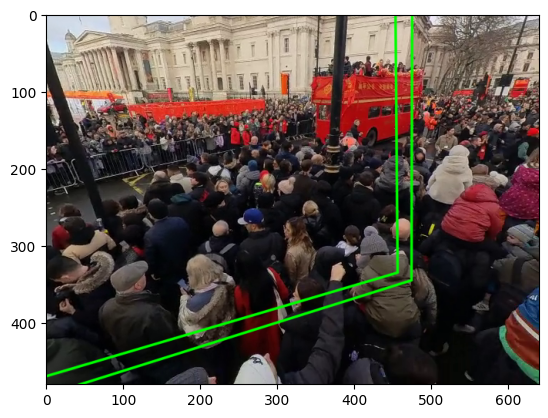

In [10]:
it, j = 0, 10
out = visualize_H((480, 640), images[j], pairs_map[(it,j)].H)
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.imshow(out)
plt.show()

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [16]:
N_cams = len(images)
N_pairs = len(image_pairs)

# Axis-angle rotation of each camera
log_R_abs = torch.randn(N_cams, 3, dtype=torch.float32, device=device)
log_R_abs[0] = 0
log_R_abs = log_R_abs.clone().detach()
log_R_abs.requires_grad = True

# Focal length of each camera
f_abs = torch.full([N_cams], 600, dtype=torch.float32, device=device)
f_abs = f_abs.clone().detach()
f_abs.requires_grad = True

# Homography between camera pairs
H_rel = torch.tensor(np.array([p.H for p in image_pairs]), dtype=torch.float32, device=device)
cam_pairs = torch.tensor([(p.i, p.j) for p in image_pairs], dtype=torch.int32, device=device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [12]:
def calc_H_rel(R, K, pairs):

    (Ri, Ki), (Rj, Kj) = [
        (R[pairs[:, c]], K[pairs[:, c]])
        for c in (0, 1)
    ]

    return Kj @ Rj @ Ri.inverse() @ Ki.inverse()


In [13]:
cam_mask = torch.ones(N_cams, 1)
cam_mask[0] = 0

optimizer = torch.optim.Adam([log_R_abs, f_abs], lr=0.1)

n_iter = 50000
for it in range(n_iter):

    optimizer.zero_grad()
    R_abs = so3.so3_exp_map(log_R_abs * cam_mask)

    K_abs = torch.eye(3).repeat(N_cams, 1, 1)
    K_abs[:, 0, 0] = f_abs
    K_abs[:, 1, 1] = f_abs

    H_rel_composed = calc_H_rel(R_abs, K_abs, cam_pairs)

    loss = torch.linalg.matrix_norm(H_rel - H_rel_composed).mean()
    loss.backward()
    optimizer.step()

    if it % 200 == 0 or it == n_iter - 1:
        status = 'it %3d; loss %1.5e' % (it, loss.item())
        print(status)


it   0; loss 9.39192e+02
it 200; loss 5.12996e+02
it 400; loss 5.07768e+02
it 600; loss 5.03073e+02
it 800; loss 5.00377e+02
it 1000; loss 4.98565e+02
it 1200; loss 4.97033e+02
it 1400; loss 4.94370e+02
it 1600; loss 4.92882e+02
it 1800; loss 4.91351e+02
it 2000; loss 4.88997e+02
it 2200; loss 4.87523e+02
it 2400; loss 4.85590e+02
it 2600; loss 4.83716e+02
it 2800; loss 4.82989e+02
it 3000; loss 4.81068e+02
it 3200; loss 4.80179e+02
it 3400; loss 4.78779e+02
it 3600; loss 4.77154e+02
it 3800; loss 4.76181e+02
it 4000; loss 4.74994e+02
it 4200; loss 4.74575e+02
it 4400; loss 4.73104e+02
it 4600; loss 4.72416e+02
it 4800; loss 4.71696e+02
it 5000; loss 4.70704e+02
it 5200; loss 4.69836e+02
it 5400; loss 4.69329e+02
it 5600; loss 4.68382e+02
it 5800; loss 4.67544e+02
it 6000; loss 4.66401e+02
it 6200; loss 4.65843e+02
it 6400; loss 4.64919e+02
it 6600; loss 4.64119e+02
it 6800; loss 4.64151e+02
it 7000; loss 4.62585e+02
it 7200; loss 4.62117e+02
it 7400; loss 4.61956e+02
it 7600; loss 4.6

In [14]:
f_abs

tensor([3271.4006,   14.5384,   19.6400,   26.5186,   32.7459,   40.8979,
          46.9216,   56.6180,   76.2347,  140.8180,  644.9381,   65.3862,
          53.1706,   61.4906,   68.1075,   76.4812,   55.3958,   43.4277,
          73.8951,  247.4340, 2165.2827,   44.5119,   53.5186,   52.6326,
          52.7154,   56.8897,   62.2482,   76.6178,  107.7445,  216.8515,
         998.5931,   36.9840,   46.0272,   50.1160,   51.4890,   53.9549,
          58.6782,   55.1039,   90.7861,  218.4594, 1672.3113,  247.0491,
         282.8867,  306.8104,  190.5022,  140.7102,  162.2248,   67.2677,
         101.9672,  258.2037, 2537.0115,  112.4668,   77.2932,   97.2127,
         140.9636,  190.1916,  244.3820,  189.9071,  187.4953,  279.9505,
        1853.5293,   26.9806,   32.6538,   36.6221,   40.1224,   32.4711,
          41.4379,   62.7997,  135.4517,  376.2446, 3469.2354,   84.0537,
         104.9173,  102.6275,  136.2173,  173.7430,  196.2445,  151.9222,
         180.2891,  334.8506, 3057.215